In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

In [3]:
df = pd.read_csv("Data/dataset.csv")
df.head(2)

,Date,SMI,SP500,USD_CHF,BondCH,BondUS
0,2003-09-17,5398.899902,1025.97,1.3807,3.700,5.71
1,2003-09-18,5422.600098,1039.58,1.3858,3.716,5.69


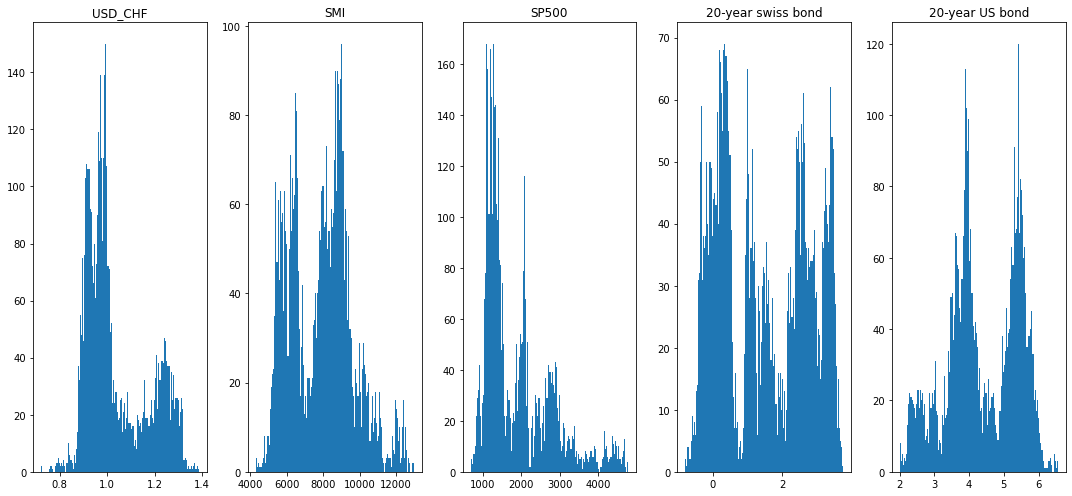

In [4]:
data = [df.USD_CHF, df.SMI, df.SP500, df.BondCH, df.BondUS]

fig = plt.figure(figsize=(15, 7))

name  = ['USD_CHF','SMI', 'SP500', '20-year swiss bond', '20-year US bond']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

In [5]:
seq_len = 15
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=seq_len, norm_=False, fraction_val_=0.1, fraction_test_=0.15)

Shape:             
X train     (3438, 15, 5), y train     (3438, 5)            
X train val (382, 15, 5) , y train val (382, 5)             
X test      (676, 15, 5) , y test      (676, 5)


ValueError: 'left' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

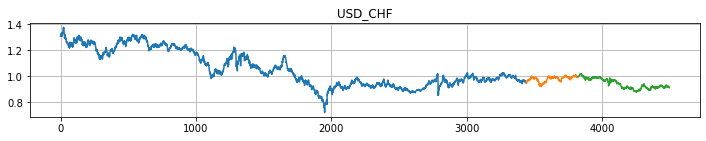

In [6]:
l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), train_y[:,i], label='Train')
  plt.plot(np.arange(l1, l2), val_y[:,i], label='Val')
  plt.plot(np.arange(l2,l3), test_y[:,i], label='Test')
  plt.grid()
  plt.legend(loc='left')

plt.tight_layout()
plt.show()


### Normalisation 

In [7]:
def min_max_norm(x_, y_, seq_len): 
  y_ = y_.copy()
  min = x_.min(axis=1)
  max = x_.max(axis=1)
  d = []
 
  for i in range(x_.shape[2]):
    res = (x_[:,:,i] - min[:,i].reshape(-1,1)) / (max[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))
    d.append(res.reshape(-1,seq_len, 1))
    y_[:,i] = ((y_[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))/ (max[:,i].reshape(-1,1) - min[:,i].reshape(-1,1))).reshape(-1,)
  return np.concatenate(d, axis=2), y_, min, max

train_x_norm, train_y_norm, min_train, max_train = min_max_norm(train_x, train_y,seq_len)
val_x_norm, val_y_norm, min_val, max_val = min_max_norm(val_x, val_y, seq_len)
test_x_norm, test_y_norm, min_test, max_test = min_max_norm(test_x, test_y, seq_len)

# Simple gru 

In [9]:
model_gru = ml.GRU_base(
        hidden_size=50,
        num_layers=1,
        input_size=1,
        out_features_lin=50,
        out_features_end=1,
        dropout=0.0,
        device='cpu')

#model_gru.to('cuda')
model_gru

GRU_base(
  (gru): GRU(1, 50, batch_first=True)
  (fc0_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=50, out_features=50, bias=True)
  (fc1_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [10]:
train_loss, val_loss = pl.train(
    model=model_gru,
    train_x_ = train_x_norm[:,:,0].reshape(-1, seq_len, 1),
    train_y_ = train_y_norm,
    val_x_ = val_x_norm[:,:,0].reshape(-1, seq_len, 1),
    val_y_= val_y_norm,
    batch_size_=512,
    num_epochs_=50,
    lr_=0.001,
    device_="cpu")
    

 20%|██        | 10/50 [00:02<00:08,  4.50it/s]

Epoch: 10/50
MSE = [train loss mean :  0.21842635] , [val loss mean:  0.23541827, MSE (last) 8.73516%]


 40%|████      | 20/50 [00:04<00:06,  4.44it/s]

Epoch: 20/50
MSE = [train loss mean :  0.06902624] , [val loss mean:  0.06882395, MSE (last) 6.25644%]


 60%|██████    | 30/50 [00:06<00:04,  4.38it/s]

Epoch: 30/50
MSE = [train loss mean :  0.06826323] , [val loss mean:  0.06364825, MSE (last) 6.26989%]


 80%|████████  | 40/50 [00:09<00:02,  4.60it/s]

Epoch: 40/50
MSE = [train loss mean :  0.06824243] , [val loss mean:  0.06307664, MSE (last) 6.26559%]


100%|██████████| 50/50 [00:11<00:00,  4.43it/s]

Epoch: 50/50
MSE = [train loss mean :  0.06856744] , [val loss mean:  0.06439207, MSE (last) 6.29555%]


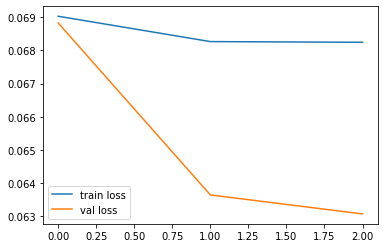

MSE: 6.568910941671005%
REAL MSE: 0.001653531187051102
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 5.699e+04
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:56:37   Log-Likelihood:                 2767.2
No. Observations:                 676   AIC:                            -5530.
Df Residuals:                     674   BIC:                            -5521.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

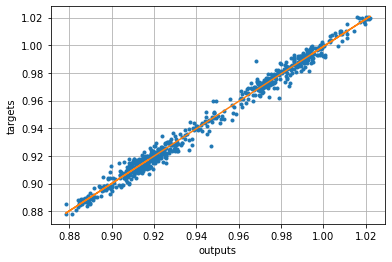

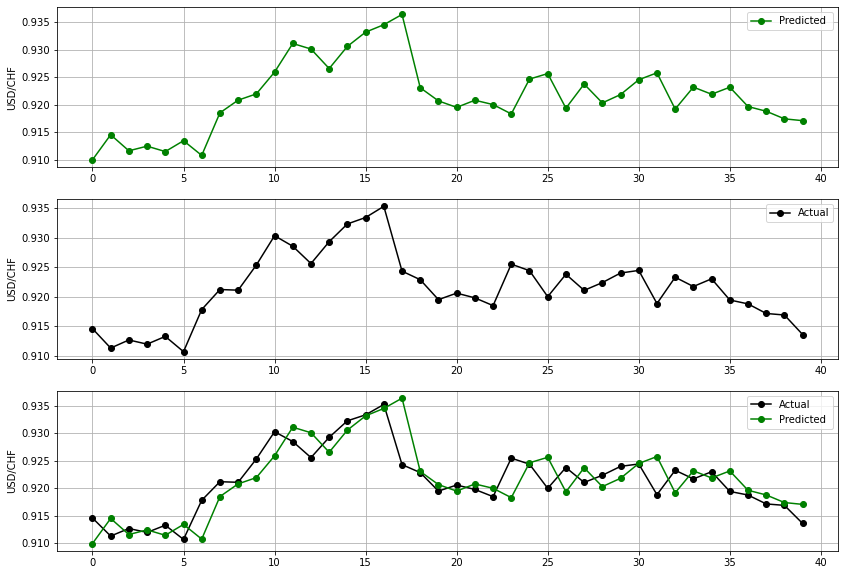

In [13]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 10)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 10)[1:] , label="val loss")
plt.legend()
plt.show()


outputs, targets, MSE = pl.evaluate(model_gru, test_x_norm[:,:,0].reshape(-1, seq_len,1), test_y_norm, device='cpu') 


min = min_test
max = max_test

outputs_simple = outputs.reshape(-1,) * (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((outputs_simple-t)**2)*100)

pl.regression_result(t, outputs_simple)
ds.plot_result_price(outputs_simple, t, nb=40)

# Simple autoencoder

In [62]:
model_ae = ml.auto_encoder(
        input_size = 1,
        nb_channel_conv = 8)
model_ae.to('cuda')
model_ae

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(8, 8, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(8, 8, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(8, 8, kernel_size=(5,), stride=(1,))
  (conv3_t): ConvTranspose1d(8, 8, kernel_size=(5,), stride=(1,))
  (conv4_t): ConvTranspose1d(8, 1, kernel_size=(6,), stride=(1,))
)

In [69]:
train_loss, val_loss = pl.train_AE(
    model=model_ae,
    train_x_ = train_x_norm[:,:,0].reshape(-1, 1, seq_len), # reshape(-1, 5, seq_len), #[:,:,0].reshape(-1, 1, seq_len),#
    train_y_ = train_y_norm,
    val_x_ = val_x_norm[:,:,0].reshape(-1, 1, seq_len), #.reshape(-1, 5, seq_len), #[:,:,0].reshape(-1, 1, seq_len),#
    val_y_= val_y_norm,
    batch_size_=512,
    num_epochs_=100,
    lr_=0.001,
    device_="cuda")


 24%|██▍       | 24/100 [00:01<00:03, 21.96it/s]

Epoch: 20/100
MSE = [train loss mean :  0.01907799] , [val loss mean:  0.01818301, MSE (last) 1.72400


 42%|████▏     | 42/100 [00:02<00:02, 19.58it/s]

Epoch: 40/100
MSE = [train loss mean :  0.01784602] , [val loss mean:  0.01716344, MSE (last) 1.70848


 63%|██████▎   | 63/100 [00:02<00:01, 21.83it/s]

Epoch: 60/100
MSE = [train loss mean :  0.01763045] , [val loss mean:  0.01702373, MSE (last) 1.69629


 84%|████████▍ | 84/100 [00:03<00:00, 21.97it/s]

Epoch: 80/100
MSE = [train loss mean :  0.01754455] , [val loss mean:  0.01691063, MSE (last) 1.68943


100%|██████████| 100/100 [00:04<00:00, 21.58it/s]

Epoch: 100/100
MSE = [train loss mean :  0.01743518] , [val loss mean:  0.01681561, MSE (last) 1.67460


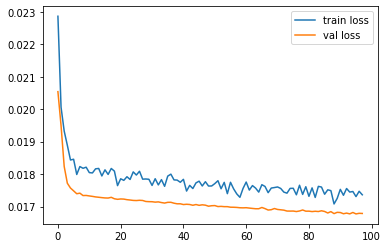

In [70]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 1)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 1)[1:] , label="val loss")
plt.legend()
plt.show()

torch.Size([676, 1, 15]) torch.Size([676, 1, 1])
MSE AE: 1.7636097967624664%


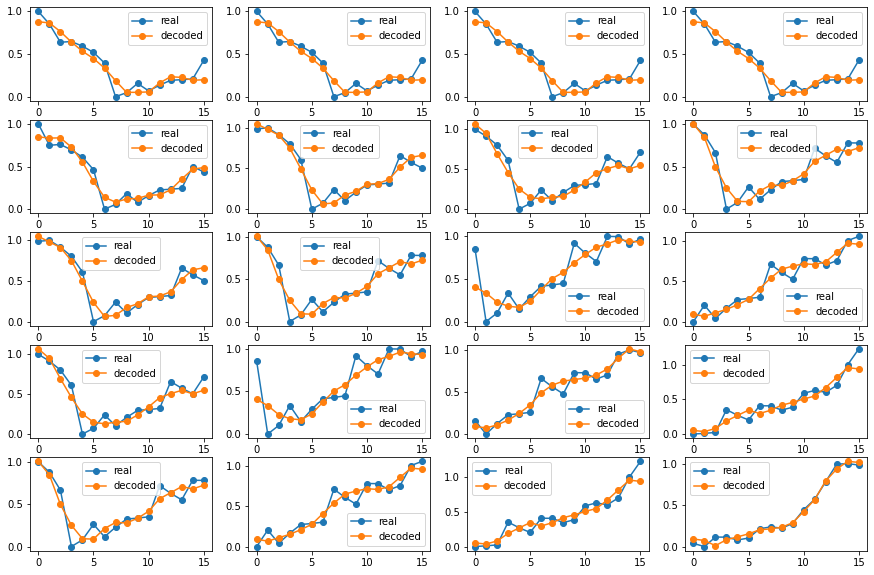

In [71]:
dec_outputs = pl.evaluate_AE(model_ae, test_x_norm[:,:,0].reshape(-1, 1, seq_len), test_y_norm, device='cuda') 

plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        ax.plot(np.concatenate((test_x_norm[i+j*i,:,0], test_y_norm[i+j*i,0].reshape(-1,))), '-o', label= "real")
        ax.plot(dec_outputs[i+j*i, 0, :], '-o', label = "decoded")
        ax.legend()
plt.show()


In [80]:
dec_outputs.shape

(676, 1, 16)

## Simple autoencoder gru model 

In [72]:
model_gru_ae = ml.GRU_base(
        hidden_size=50,
        num_layers=1,
        input_size=1,
        out_features_lin=50,
        out_features_end=1,
        dropout=0.0,
        device='cuda')

model_gru_ae.to('cuda')
model_gru_ae

GRU_base(
  (gru): GRU(1, 16, batch_first=True)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

 28%|██▊       | 14/50 [00:01<00:02, 13.76it/s]

Epoch: 10/50
MSE = [train loss mean :  0.09147079] , [val loss mean:  0.21245115, MSE (last) 15.06426%]


 44%|████▍     | 22/50 [00:02<00:01, 17.55it/s]

Epoch: 20/50
MSE = [train loss mean :  0.07099061] , [val loss mean:  0.09912724, MSE (last) 6.60886%]


 68%|██████▊   | 34/50 [00:02<00:00, 19.31it/s]

Epoch: 30/50
MSE = [train loss mean :  0.07161223] , [val loss mean:  0.06989007, MSE (last) 6.60295%]


 88%|████████▊ | 44/50 [00:03<00:00, 19.79it/s]

Epoch: 40/50
MSE = [train loss mean :  0.07051993] , [val loss mean:  0.07542724, MSE (last) 7.08760%]


100%|██████████| 50/50 [00:03<00:00, 13.05it/s]

Epoch: 50/50
MSE = [train loss mean :  0.07028044] , [val loss mean:  0.07048176, MSE (last) 6.40805%]


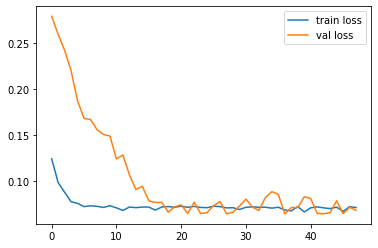

In [81]:
train_loss, val_loss = pl.train_AEandGRU(
    model_AE= model_ae,
    model = model_gru_ae, 
    train_x_ = train_x_norm[:,:,0].reshape(-1, 1, seq_len),#.reshape(-1, 5, seq_len), #
    train_y_ = train_y_norm,
    val_x_ = val_x_norm[:,:,0].reshape(-1, 1, seq_len),#.reshape(-1, 5, seq_len), #
    val_y_= val_y_norm,
    seq_len = seq_len+1, 
    batch_size_=512,
    num_epochs_=50,
    lr_=0.001,
    device_="cuda")

plt.plot(pl.smooth_loss(train_loss, chunksize = 1)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 1)[1:] , label="val loss")
plt.legend()
plt.show()

MSE: 6.644059305172469%
REAL MSE: 0.0016964273503426177
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 5.519e+04
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:13:10   Log-Likelihood:                 2756.5
No. Observations:                 676   AIC:                            -5509.
Df Residuals:                     674   BIC:                            -5500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

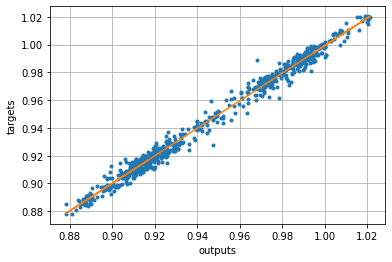

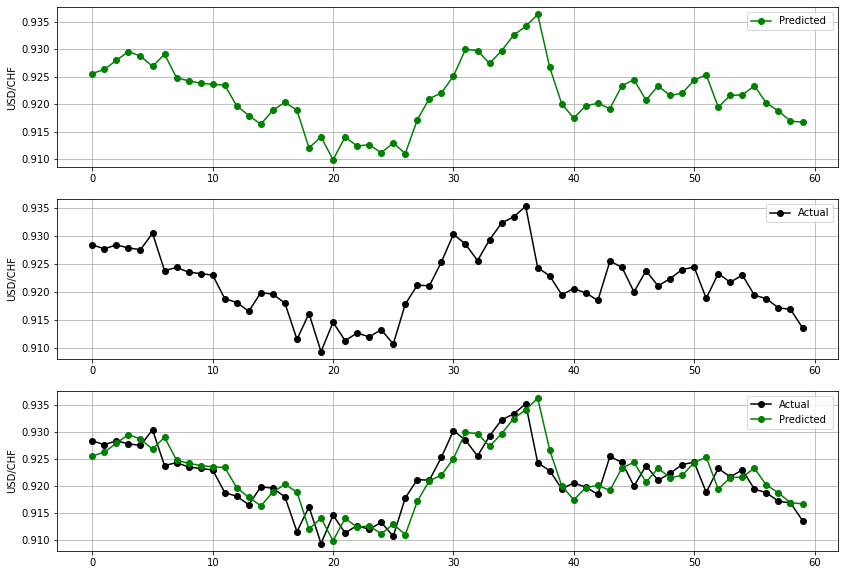

In [82]:
outputs, targets, MSE = pl.evaluate_AEandGRU(model_ae, model_gru_ae, test_x_norm[:,:,0].reshape(-1, 1, seq_len), test_y_norm, seq_len=seq_len+1, device='cuda') 

min = min_test
max = max_test

outputs_simple = outputs.reshape(-1,) * (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((outputs_simple-t)**2)*100)

pl.regression_result(t, outputs_simple)
ds.plot_result_price(outputs_simple, t, nb=60)

# ALL feature 

In [237]:
model_ae = ml.auto_encoder(
        input_size = 5,
        nb_channel_conv = 16)
model_ae.to('cuda')
model_ae

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(5, 16, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
  (conv4): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(16, 16, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(1,))
  (conv3_t): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(1,))
  (conv4_t): ConvTranspose1d(16, 5, kernel_size=(6,), stride=(1,))
)

In [238]:
train_loss, val_loss = pl.train_AE(
    model=model_ae,
    train_x_ = np.swapaxes(train_x_norm,1,2), #.reshape(-1, 5, seq_len), #[:,:,0].reshape(-1, 1, seq_len),#
    train_y_ = train_y_norm,
    val_x_ =  np.swapaxes(val_x_norm,1,2), #[:,:,0].reshape(-1, 1, seq_len),#
    val_y_= val_y_norm,
    batch_size_=512,
    num_epochs_=500,
    lr_=0.001,
    device_="cuda")

 21%|██        | 104/500 [00:07<00:22, 17.86it/s]

Epoch: 100/500
MSE = [train loss mean :  0.09809868] , [val loss mean:  0.09521382, MSE (last) 7.20551


 40%|████      | 202/500 [00:12<00:14, 21.16it/s]

Epoch: 200/500
MSE = [train loss mean :  0.06396056] , [val loss mean:  0.06405569, MSE (last) 5.26845


 61%|██████    | 303/500 [00:17<00:09, 21.29it/s]

Epoch: 300/500
MSE = [train loss mean :  0.04515086] , [val loss mean:  0.04438506, MSE (last) 4.14613


 81%|████████  | 403/500 [00:22<00:04, 21.19it/s]

Epoch: 400/500
MSE = [train loss mean :  0.04150732] , [val loss mean:  0.04101181, MSE (last) 4.06986


100%|██████████| 500/500 [00:26<00:00, 18.53it/s]

Epoch: 500/500
MSE = [train loss mean :  0.04090973] , [val loss mean:  0.04057007, MSE (last) 4.04518


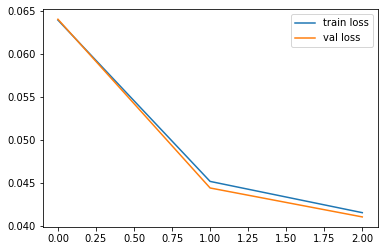

In [239]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 100)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 100)[1:] , label="val loss")
plt.legend()
plt.show()

MSE AE: 4.445929080247879%


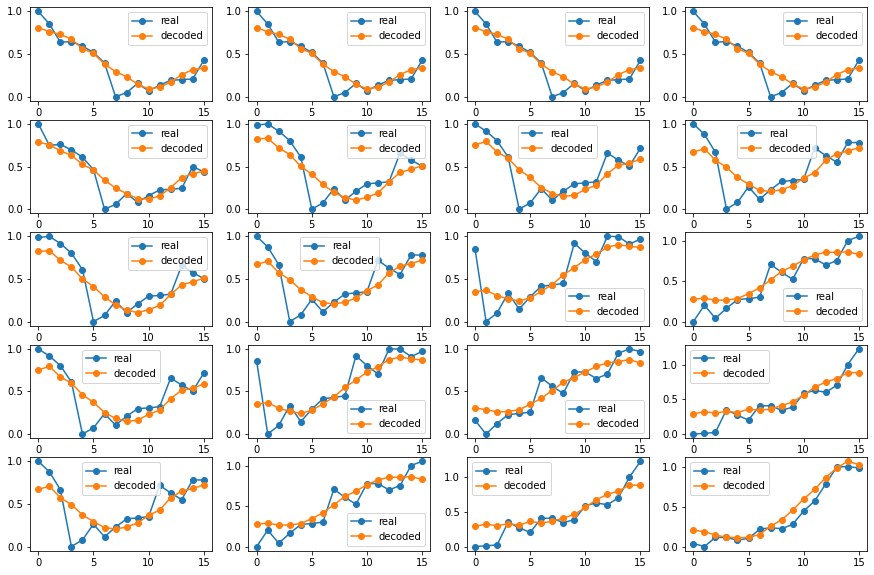

--------------------------------------


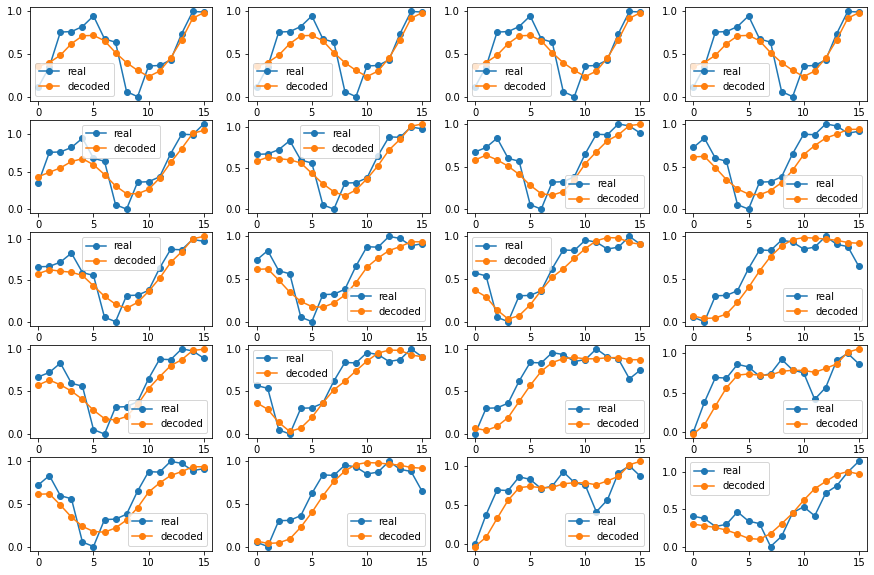

--------------------------------------


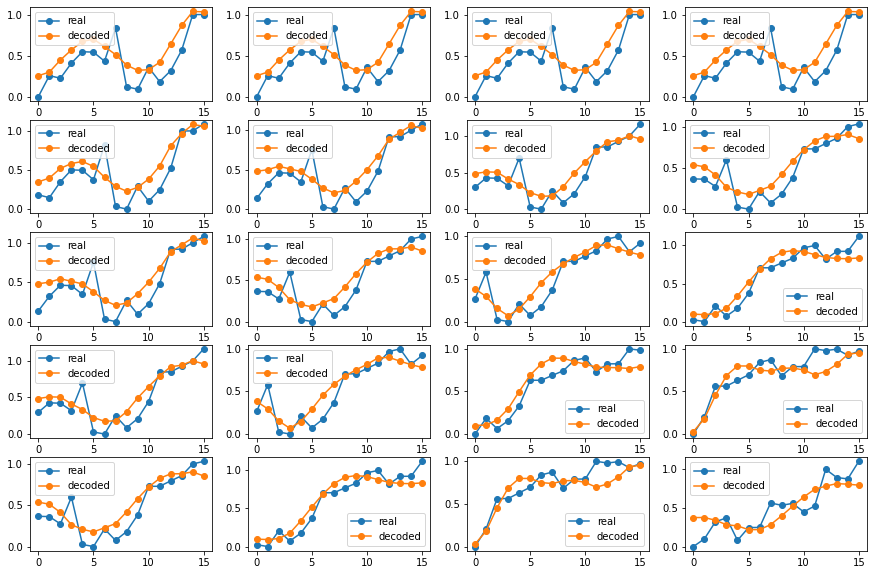

--------------------------------------


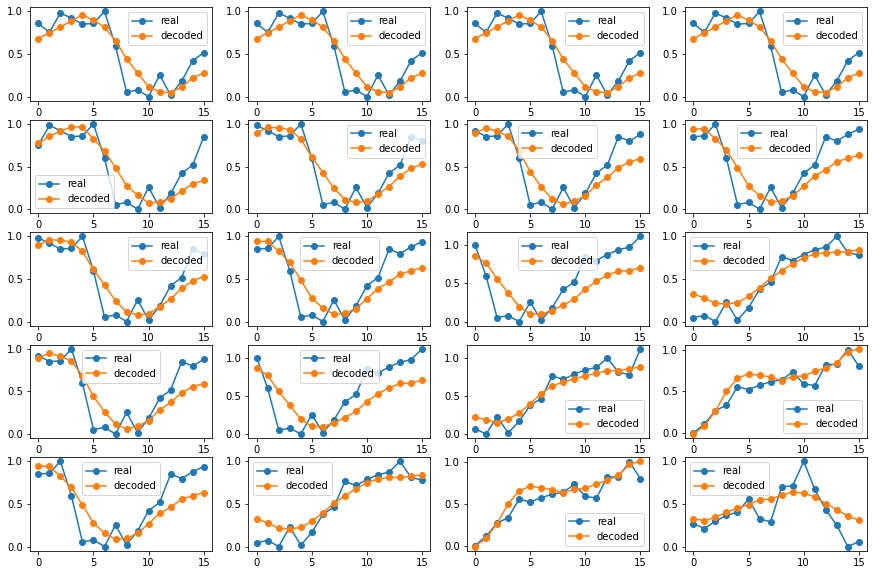

--------------------------------------


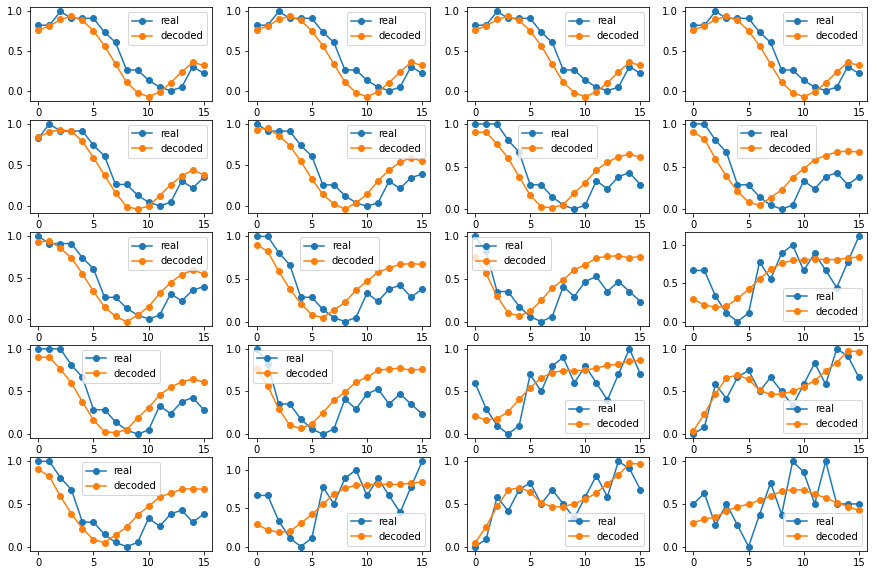

--------------------------------------


In [240]:
dec_outputs = pl.evaluate_AE(model_ae, np.swapaxes(test_x_norm,1,2), test_y_norm, device='cuda') 

for idx in range(5):
  plt.figure(figsize=(15,10))
  plots = []
  for i in range(5):
      for j in range(4):
          ax = plt.subplot2grid((5,4), (i,j))
          ax.plot(np.concatenate((test_x_norm[i+j*i,:,idx], test_y_norm[i+j*i,idx].reshape(-1,))), '-o', label= "real")
          ax.plot(dec_outputs[i+j*i, idx, :], '-o', label = "decoded")
          ax.legend()
  plt.show()
  print("--------------------------------------")

In [243]:
model_gru_ae = ml.GRU_base(
        hidden_size=50,
        num_layers=1,
        input_size=5,
        out_features_lin=50,
        out_features_end=1,
        dropout=0.0,
        device='cuda')

model_gru_ae.to('cuda')
model_gru_ae

GRU_base(
  (gru): GRU(5, 50, batch_first=True)
  (fc0_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=50, out_features=50, bias=True)
  (fc1_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

 24%|██▍       | 12/50 [00:00<00:01, 20.74it/s]

Epoch: 10/50
MSE = [train loss mean :  0.08707003] , [val loss mean:  0.10920258, MSE (last) 10.99951%]


 48%|████▊     | 24/50 [00:01<00:01, 20.35it/s]

Epoch: 20/50
MSE = [train loss mean :  0.08597172] , [val loss mean:  0.11197167, MSE (last) 11.42441%]


 66%|██████▌   | 33/50 [00:01<00:00, 20.46it/s]

Epoch: 30/50
MSE = [train loss mean :  0.08311444] , [val loss mean:  0.11287106, MSE (last) 11.49315%]


 84%|████████▍ | 42/50 [00:02<00:00, 20.09it/s]

Epoch: 40/50
MSE = [train loss mean :  0.08233783] , [val loss mean:  0.11427245, MSE (last) 12.42797%]


100%|██████████| 50/50 [00:02<00:00, 19.36it/s]


Epoch: 50/50
MSE = [train loss mean :  0.08068001] , [val loss mean:  0.11272289, MSE (last) 11.23778%]


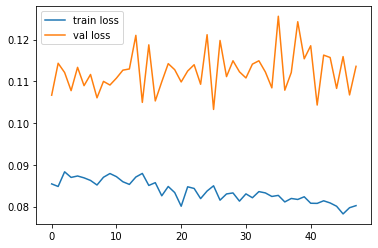

In [256]:
train_loss, val_loss = pl.train_AEandGRU(
    model_AE= model_ae,
    model = model_gru_ae, 
    train_x_ = np.swapaxes(train_x_norm,1,2), #train_x_norm[:,:,0].reshape(-1, 1, seq_len),#.reshape(-1, 5, seq_len), #
    train_y_ = train_y_norm,
    val_x_ = np.swapaxes(val_x_norm,1,2), #val_x_norm[:,:,0].reshape(-1, 1, seq_len),#.reshape(-1, 5, seq_len), #
    val_y_= val_y_norm,
    seq_len = seq_len+1, 
    batch_size_=512,
    num_epochs_=50,
    lr_=0.001,
    device_="cuda")

plt.plot(pl.smooth_loss(train_loss, chunksize = 1)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 1)[1:] , label="val loss")
plt.legend()
plt.show()

MSE: 11.914488078074134%
REAL MSE: 0.0034263129724215096
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 2.703e+04
Date:                Sun, 04 Dec 2022   Prob (F-statistic):               0.00
Time:                        17:41:08   Log-Likelihood:                 2519.5
No. Observations:                 676   AIC:                            -5035.
Df Residuals:                     674   BIC:                            -5026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

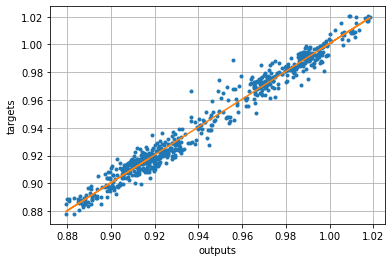

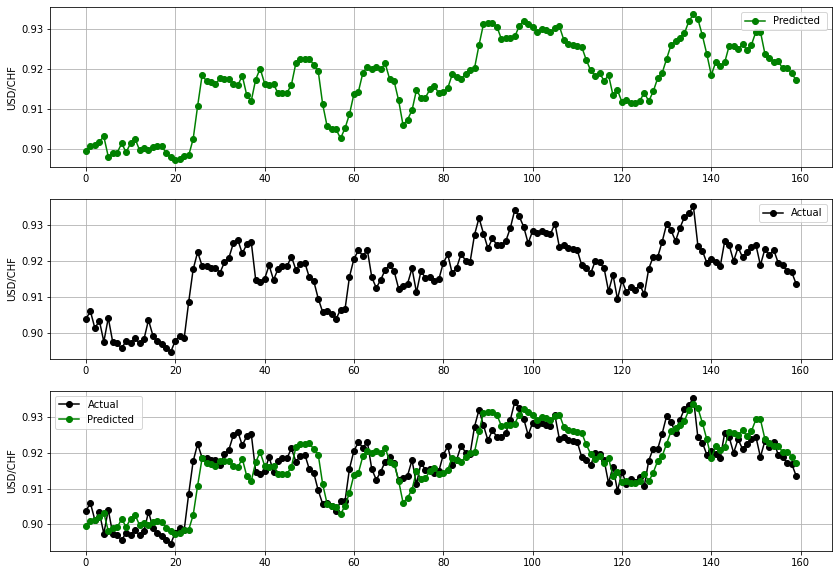

In [258]:
outputs, targets, MSE = pl.evaluate_AEandGRU(model_ae, model_gru_ae, np.swapaxes(test_x_norm,1,2), test_y_norm, seq_len=seq_len+1, device='cuda') 

min = min_test
max = max_test

outputs_simple = outputs.reshape(-1,) * (max[:,0]- min[:,0]) + min[:,0] 
t = targets * (max[:,0]- min[:,0]) + min[:,0]
print("REAL MSE:", np.mean((outputs_simple-t)**2)*100)

pl.regression_result(t, outputs_simple)
ds.plot_result_price(outputs_simple, t, nb=160)